# 커스텀 상태 정의

이번 튜토리얼에서는 상태의 메시지 목록에 의존하지 않고 복잡한 동작을 정의하기 위해 상태에 새로운 필드를 추가합니다. 챗봇은 검색 도구를 사용하여 특정 정보를 찾아 검토를 위해 담당자에게 전달합니다.

## 1. 환경 설정

In [253]:
# 환경 변수 확인
from dotenv import load_dotenv
import os
load_dotenv(override=True)

TAVILY_API_KEY= os.environ.get("TAVILY_API_KEY")
print(TAVILY_API_KEY[:20])

tvly-dev-GUT1o6jP4Og


## 2. 상태에 키 추가

In [254]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]
    # 키 추가
    name: str
    birthday: str

## 3. 상태 업데이트

State의 추가된 키 값들을 도구 내부에서 업데이트 합니다.

In [255]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.types import Command, interrupt

# 📌 tool 정의
# 상태 업데이트를 위해 ToolMessage를 생성하기 때문에, 일반적으로 해당 도구 호출에 대응하는 ID가 필요합니다.
# 이때 LangChain의 InjectedToolCallId를 사용하면, 이 인자가 도구의 스키마에서 모델에게 노출되지 않아야 함을 나타낼 수 있습니다.
@tool
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """사람의 개입을 요청합니다."""
    human_response = interrupt(
        {
            "question": "이 내용이 정확한가요?",
            "name": name,
            "birthday": birthday,
        },
    )
    
    # 정보가 정확하다면, 상태를 그대로 업데이트하세요.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "정확한 정보입니다."
    # 그렇지 않은 경우, 사람의 개입으로부터 정보를 입력받으세요.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"정보를 다음과 같이 수정했으므로 출시일에 생일의 데이터를 적용하세요: {human_response}"

    # 이번에는 도구 내부에서 ToolMessage를 사용하여 상태를 명시적으로 업데이트합니다.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    print("*** UPDATE :", state_update)
    # 도구에서 상태를 업데이트하기 위해 Command 객체를 반환합니다.
    return Command(update=state_update)

In [256]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str  # ← 추가
    birthday: str  # ← 추가

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
# 도구 추가
tools = [tool, human_assistance]
    
def chatbot(state: State):
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    llm_with_tools = llm.bind_tools(tools)


    # # ✅ name과 birthday가 있으면 system message로 삽입 
    # system_msg = ""
    # if "name" in state:
    #     system_msg += f"name: {state['name']}\n"
    # if "birthday" in state:
    #     system_msg += f"birthday: {state['birthday']}"

    # # 전체 메시지 구성
    # messages = []
    # if system_msg.strip():
    #     messages.append({"role": "system", "content": system_msg})
    # messages.extend(state["messages"])  # 기존 user/ai message들

    # -----
    # print('\n\n', '📌', state["messages"], '\n\n')

    
    response = llm_with_tools.invoke(state["messages"])
    # 도구 실행 중에 중단(interrupt)할 것이기 때문에,
    # 실행 재개 시 도구 호출이 반복되지 않도록
    # 병렬 도구 호출을 비활성화합니다.
    assert len(response.tool_calls) <= 1
    return {"messages": [response]}

graph_builder.add_node("chatbot", chatbot)

# 📌 ToolNode 추가
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# 
graph_builder.add_conditional_edges(
    "chatbot",
    # 📌 "tools" 또는 END를 리턴한다.
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

## 3. 그래프 컴파일

In [257]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

## 4. 그래프 시각화

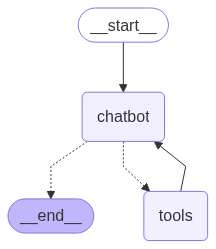

In [258]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## 5. 챗봇 실행

챗봇에게 LangGraph 라이브러리의 **생일(birthday)** 을 찾아보라고 요청한 뒤, 필요한 정보를 얻으면 `human_assistance` 도구를 사용하도록 지시하세요.
또한 `name`과 `birthday`를 도구에 전달하는 인자(arguments)로 설정하면,챗봇이 이 필드들에 대한 **값을 반드시 생성하도록 유도할 수 있습니다.**
즉, 챗봇이 name과 birthday 정보를 채워 넣어야만 도구를 호출할 수 있으므로, 이 두 항목을 **자동으로 제안하게 만드는** 방식입니다.

In [259]:
user_input = (
    "LangGraph가 언제 출시되었는지 찾아서 알려주세요?"
    "답을 찾으면 human_assistance 도구를 사용해 검토를 요청하세요."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream({"messages": [{"role": "user", "content": user_input}]}, config, stream_mode="values",)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

LangGraph가 언제 출시되었는지 찾아서 알려주세요?답을 찾으면 human_assistance 도구를 사용해 검토를 요청하세요.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_nRTbscZMAOX6ArawxlWerEUG)
 Call ID: call_nRTbscZMAOX6ArawxlWerEUG
  Args:
    query: LangGraph 출시일
    search_depth: advanced
================================= Tool Message =================================
Name: tavily_search

{"query": "LangGraph 출시일", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "What is LangGraph? - GeeksforGeeks", "url": "https://www.geeksforgeeks.org/machine-learning/what-is-langgraph/", "content": "LangGraph is a Python library that helps you build applications like chatbots or AI agents by organizing their logic step-by-step using state machine model. This step configures your Gemini API key and then we create a simple function ask_gemini that takes user input

현재 `human_assistance` 도구에 접근한 상태입니다.

## 6. 실행 재개

챗봇이 올바른 날짜를 식별하지 못했으므로 다음 정보를 제공하세요.

In [260]:
from langgraph.types import Command

human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "2020-01-01",
    },
)

# human_command = Command(
#     resume={
#         "correct": "y",
#     },
# )

In [261]:
events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_YaafCRZQbrcrTZfEvXIydf9b)
 Call ID: call_YaafCRZQbrcrTZfEvXIydf9b
  Args:
    name: LangGraph
    birthday: 2023-01-01
*** UPDATE : {'name': 'LangGraph', 'birthday': '2020-01-01', 'messages': [ToolMessage(content="정보를 다음과 같이 수정했으므로 출시일에 생일의 데이터를 적용하세요: {'name': 'LangGraph', 'birthday': '2020-01-01'}", tool_call_id='call_YaafCRZQbrcrTZfEvXIydf9b')]}
================================= Tool Message =================================
Name: human_assistance

정보를 다음과 같이 수정했으므로 출시일에 생일의 데이터를 적용하세요: {'name': 'LangGraph', 'birthday': '2020-01-01'}
================================== Ai Message ==================================

LangGraph는 2020년 1월 1일에 출시되었습니다.


In [243]:
# events = graph.stream(human_command, config, stream_mode="values")
# for event in events:
#     if "messages" in event:
#         event["messages"][-1].pretty_print()
#     if "name" in event:
#         print("name:", event["name"])
#     if "birthday" in event:
#         print("birthday:", event["birthday"])